### analysis of PCB trials
The dataset contains mixed males and females.
The dataset also contains mixed genotypes (wt and sert-Cre hets)
# The conclusion here is that PCB is not effective under these conditions
* 2/15/2023 adding a new cohot with PCB given after SEFLB

In [1]:
import os
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
# sns.set(font_scale = 1.5)
sns.set_style("white")
import pandas as pd
import datetime
%matplotlib inline

In [2]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=de45bd17a49a40c06723ed5f671a67a727dcdba14886548d984cd3f81ba69bcb
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [3]:
import pingouin as pg

In [4]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/Turi_lab/Data/PTSD_project/!analysis/saveFolder/'

# base_data_path = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/'
# save_path = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/saveFolder/'

Mounted at /content/drive


In [9]:
worksheet = gc.open('all_cohorts_freezing_FINAL').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(data)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.reset_index(inplace=True, drop=True)

# replacing NA to NaN
df.replace('NA', np.NaN, inplace=True)
# changing `freezing` dtype to float
df['freezing'] = pd.to_numeric(df['freezing'],
                                        downcast='float')
# adding unique ID-s based on `id` and `cohort`
df['cohort_id']= df['cohort']+'_'+df['id']

df['date_time'] = df['date']+' '+df['time']

#this brakes. 
# df['man_date_time'] = pd.to_datetime(df['date_time'])

df['date'] = df['date'].astype('datetime64[ns]', copy=False)

print(df.dtypes)
df.head()
# TODO add DOB-s
# calculate time after SEFLA column

0
freezing                    float32
genotype                     object
id                           object
day                          object
condition                    object
sex                          object
cohort                       object
exposure_mins                object
analyzed_duration            object
date                 datetime64[ns]
time                         object
els                          object
psilocybin                   object
cohort_id                    object
date_time                    object
dtype: object


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,date_time
0,3.510000,2aFlox_het,5HT2Afl05a-5,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,n,ptsd1_5HT2Afl05a-5,4/3/2021 1:34 PM
1,3.080000,wt,5HT2Afl05a-7,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,n,ptsd1_5HT2Afl05a-7,4/3/2021 1:34 PM
2,0.800000,wt,5HT2ACre01a-3,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,n,ptsd1_5HT2ACre01a-3,4/3/2021 1:34 PM
3,0.700000,wt,sert26a-3,sefla,control,male,ptsd1,60,60,2021-04-03,1:58 PM,n,n,ptsd1_sert26a-3,4/3/2021 1:58 PM
4,45.130001,wt,5HT2Afl5a-6,sefla,sefl,male,ptsd1,60,60,2021-04-03,3:03 PM,n,n,ptsd1_5HT2Afl5a-6,4/3/2021 3:03 PM


In [12]:
non_els_df = df.query("els == 'n' & genotype == 'wt'")
cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6','ptsd8', 'ptsd9',
               'ptsd10', 'els1', 'els2' 'ptsd12', 'ptsd13', 'ptsd14',
               'ptsd15']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']
exp_mice_df = non_els_df[(non_els_df['cohort'].isin(cohort_list)) & 
                              (non_els_df['day'].isin(day_list))]

In [13]:
exp_mice_df['cohort'].unique()

array(['ptsd2', 'ptsd3', 'ptsd4', 'ptsd5', 'ptsd6', 'ptsd9', 'ptsd10',
       'els1', 'ptsd13', 'ptsd14', 'ptsd15'], dtype=object)

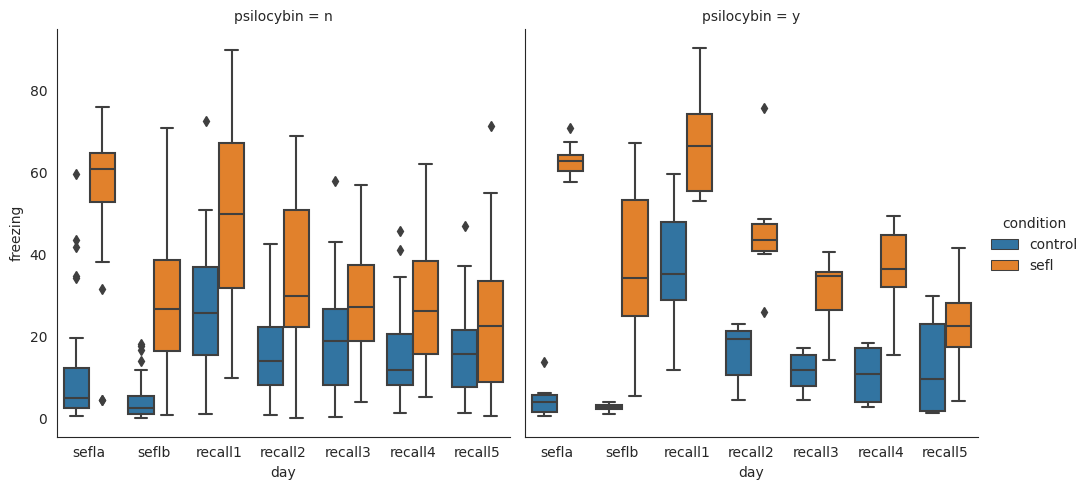

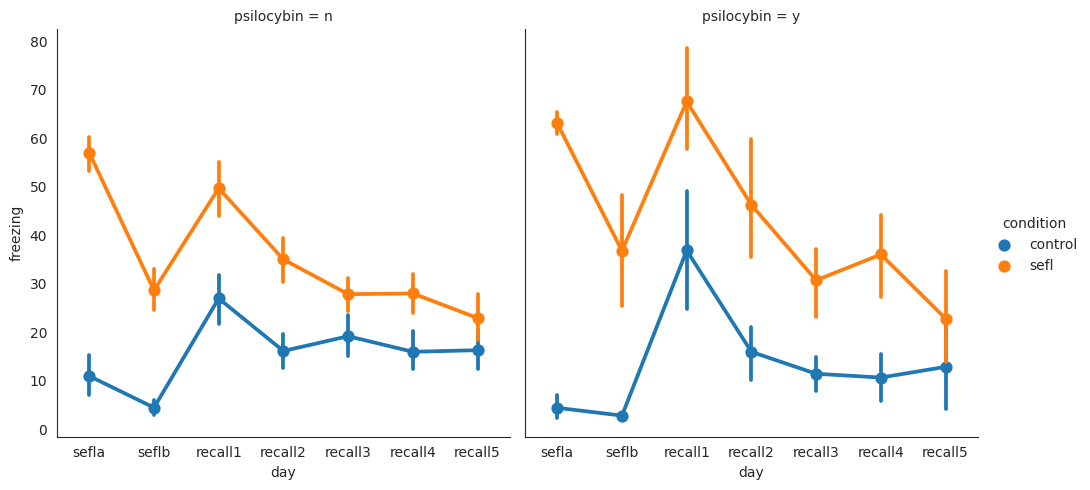

In [14]:
g = sns.catplot(data=exp_mice_df, y='freezing', x='day', hue='condition', 
                col='psilocybin', kind='box', order=['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5'])
g2 = sns.catplot(data=exp_mice_df, y='freezing', x='day', hue='condition', 
                col='psilocybin', kind='point', order=['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5'])

In [15]:
exp_mice_df.groupby(['condition', 'psilocybin', 'sex'])['cohort_id'].nunique()

condition  psilocybin  sex   
control    n           female    12
                       male      27
           y           male       7
sefl       n           female    18
                       male      38
           y           male       7
Name: cohort_id, dtype: int64

<ipython-input-16-a539b5d1b87a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_mice_df['day'] = pd.Categorical(exp_mice_df['day'],


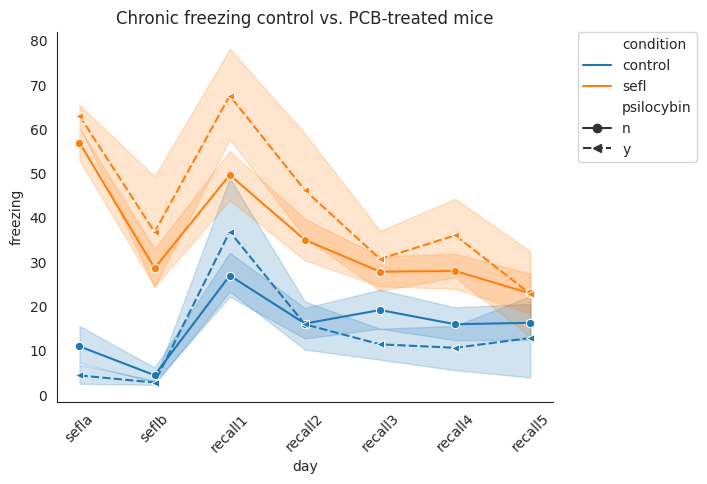

In [16]:
exp_mice_df['day'] = pd.Categorical(exp_mice_df['day'], 
                                     categories=['sefla','seflb','recall1',
                                                 'recall2', 'recall3','recall4',
                                                 'recall5'],
                                     ordered=True)
g = sns.lineplot(data=exp_mice_df, y='freezing', x='day', hue='condition', 
                style='psilocybin', markers=['o', '<'],
                legend=True)
plt.title('Chronic freezing control vs. PCB-treated mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

## Only males

In [17]:
male_non_els_df = df.query("els == 'n' & genotype == 'wt' & sex== 'male'")
cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6','ptsd8', 'ptsd9',
               'ptsd10', 'els1', 'els2' 'ptsd12', 'ptsd13', 'ptsd14',
               'ptsd15']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']
male_exp_mice_df = male_non_els_df[(non_els_df['cohort'].isin(cohort_list)) & 
                              (non_els_df['day'].isin(day_list))]

<ipython-input-17-13c62bc46a40>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_exp_mice_df = male_non_els_df[(non_els_df['cohort'].isin(cohort_list)) &


In [18]:
male_exp_mice_df.groupby(['condition', 'psilocybin', 'sex'])['cohort_id'].nunique()

condition  psilocybin  sex 
control    n           male    27
           y           male     7
sefl       n           male    38
           y           male     7
Name: cohort_id, dtype: int64

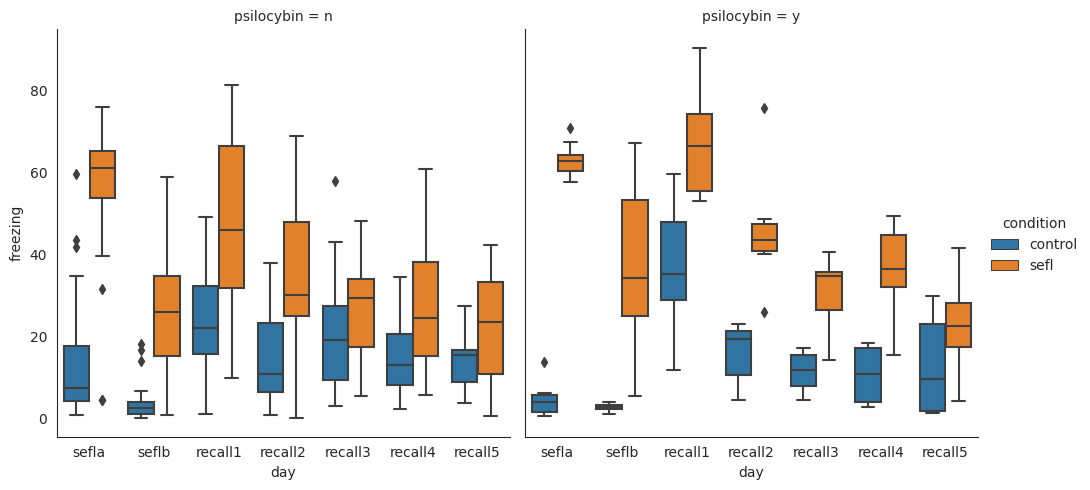

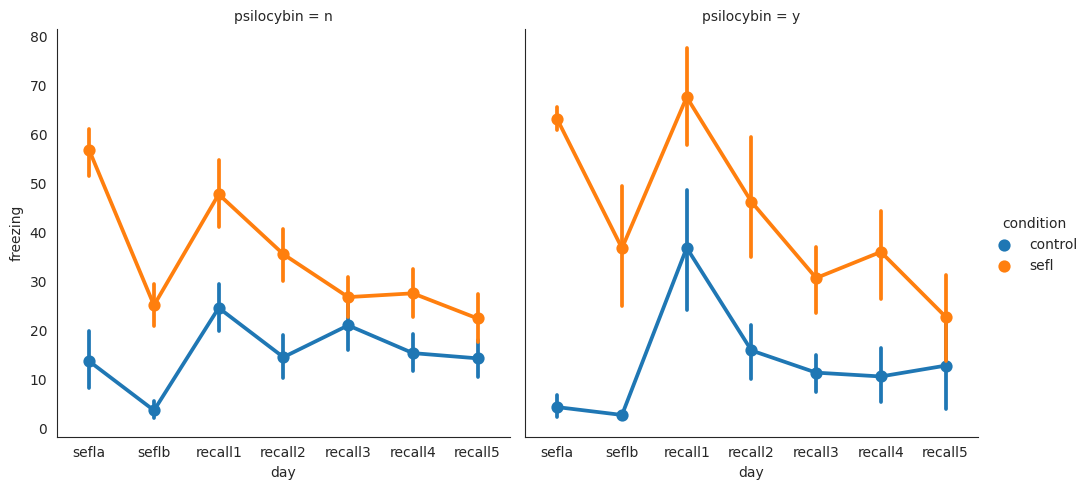

In [19]:
g = sns.catplot(data=male_exp_mice_df, y='freezing', x='day', hue='condition', 
                col='psilocybin', kind='box', order=['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5'])
g2 = sns.catplot(data=male_exp_mice_df, y='freezing', x='day', hue='condition', 
                col='psilocybin', kind='point', order=['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5'])

<ipython-input-22-5918fb8362b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_exp_mice_df['day'] = pd.Categorical(male_exp_mice_df['day'],


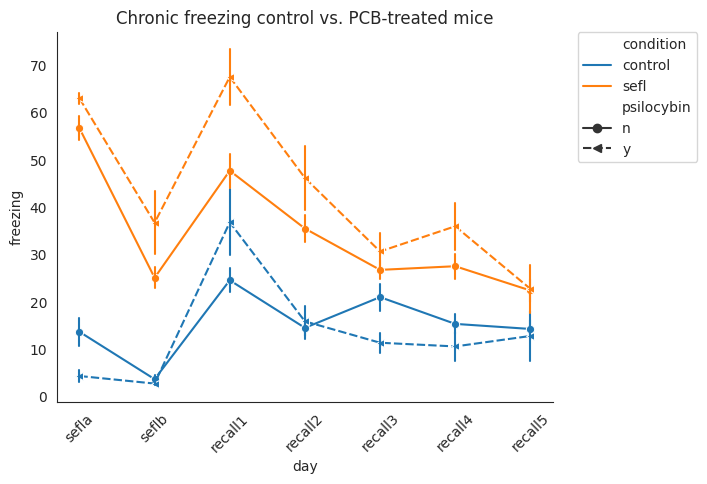

In [22]:
male_exp_mice_df['day'] = pd.Categorical(male_exp_mice_df['day'], 
                                     categories=['sefla','seflb','recall1',
                                                 'recall2', 'recall3','recall4',
                                                 'recall5'],
                                     ordered=True)
g = sns.lineplot(data=male_exp_mice_df, y='freezing', x='day', hue='condition', 
                style='psilocybin', markers=['o', '<'],
                legend=True, errorbar='se', err_style='bars')
plt.title('Chronic freezing control vs. PCB-treated mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

In [ ]:
worksheet = gc.open('pcb_mice').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)
# Convert to a DataFrame and render.
import pandas as pd
pcb_df = pd.DataFrame.from_records(data)
pcb_df.columns = pcb_df.iloc[0]
pcb_df.drop(pcb_df.index[0], inplace=True)
pcb_df['cohort_id']=pcb_df['cohort']+'_'+pcb_df['id']


pcb_df.head(2)
# df.dtypes
pcb_df.shape

(39, 8)

In [ ]:
keys = list(pcb_df['cohort_id'].values)
filtered_df = df[df['cohort_id'].isin(keys)]
filtered_df.shape

(336, 14)

In [ ]:
merged_df = filtered_df.merge(pcb_df, left_on='cohort_id',
                              right_on='cohort_id')
merged_df.tail()

,freezing,genotype,id_x,day,condition,sex,cohort_x,exposure_mins,analyzed_duration,date,time,cohort_id,date_time,man_date_time,cohort_y,id_y,pcb_date,pcb_condition,pcb_trial_date,pcb_trial,pre_trial
331,46.734001,sert_het,917-3,recall2,SEFL,female,ptsd8,5,5,2021-12-29,2:21 PM,ptsd8_917-3,12/29/2021 2:21 PM,2021-12-29 14:21:00,ptsd8,917-3,1/22/22,pcb,7/27/2022,recall6,recall5
332,23.716000,sert_het,917-3,recall3,SEFL,female,ptsd8,5,5,2022-01-05,3:03 PM,ptsd8_917-3,1/5/2022 3:03 PM,2022-01-05 15:03:00,ptsd8,917-3,1/22/22,pcb,7/27/2022,recall6,recall5
333,30.282000,sert_het,917-3,recall4,SEFL,female,ptsd8,5,5,2022-01-13,3:09 PM,ptsd8_917-3,1/13/2022 3:09 PM,2022-01-13 15:09:00,ptsd8,917-3,1/22/22,pcb,7/27/2022,recall6,recall5
334,22.344000,sert_het,917-3,recall5,SEFL,female,ptsd8,5,5,2022-01-13,3:09 PM,ptsd8_917-3,1/13/2022 3:09 PM,2022-01-13 15:09:00,ptsd8,917-3,1/22/22,pcb,7/27/2022,recall6,recall5
335,11.162000,sert_het,917-3,recall6,SEFL,female,ptsd8,5,5,2022-01-27,5:03 PM,ptsd8_917-3,1/27/2022 5:03 PM,2022-01-27 17:03:00,ptsd8,917-3,1/22/22,pcb,7/27/2022,recall6,recall5


In [ ]:
ctrl_df = merged_df[merged_df['day']==merged_df['pre_trial']]
ctrl_df.reset_index(drop=True, inplace=True)
ctrl_df['drug_cond'] = 'pre'

psilo_df = merged_df[merged_df['day']==merged_df['pcb_trial']]
psilo_df.reset_index(drop=True, inplace=True)
psilo_df['drug_cond'] = 'post'

ctrl_df.head()

pcb_plot = ctrl_df.append(psilo_df)

pcb_plot.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,freezing,genotype,id_x,day,condition,sex,cohort_x,exposure_mins,analyzed_duration,date,time,cohort_id,date_time,man_date_time,cohort_y,id_y,pcb_date,pcb_condition,pcb_trial_date,pcb_trial,pre_trial,drug_cond
0,42.194,wt,10,recall5,SEFL,male,ptsd3,5,5,2021-06-24,2:21 PM,ptsd3_10,6/24/2021 2:21 PM,2021-06-24 14:21:00,ptsd3,10,07/02/2021,pcb,7/8/2021,recall6,recall5,pre
1,24.122,wt,12,recall5,SEFL,male,ptsd3,5,5,2021-06-24,2:21 PM,ptsd3_12,6/24/2021 2:21 PM,2021-06-24 14:21:00,ptsd3,12,07/02/2021,sal,7/8/2021,recall6,recall5,pre


In [ ]:
control = pcb_plot[pcb_plot['condition']== 'control']['cohort_id'].nunique()
sefl = pcb_plot[pcb_plot['condition']== 'SEFL']['cohort_id'].nunique()

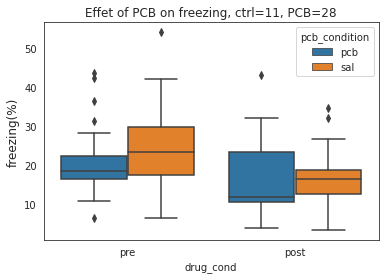

In [ ]:

g = sns.boxplot(data=pcb_plot, x='drug_cond', y='freezing', hue='pcb_condition',
                hue_order=['pcb','sal'])
# plt.xlabel("", size=12)
plt.ylabel("freezing(%)", size=12)
plt.title(f"Effet of PCB on freezing, ctrl={control}, PCB={sefl}", size=12)
# plt.savefig(os.path.join(save_path, 'Effect of PCB on freezing in SEFL and ctrl.png'),
#             transparent=True, dpi=300)

In [ ]:

# g = sns.catplot(data=pcb_plot, x='drug_cond', y='freezing',
#                 hue='pcb_condition', col='condition', kind='box',
#                 )
# g.set_ylabels('freezing(%)', fontsize=20)
# g.set_xlabels('psilocybin trial', fontsize=20)
# titles = [f"SEFL mice N={pcb_plot[pcb_plot['condition']=='SEFL']['cohort_id'].nunique()}",
#           f"Control mice N={pcb_plot[pcb_plot['condition']=='control']['cohort_id'].nunique()}"]


# for ax, title in zip(g.axes.flat, titles):
#   ax.set_title(label=title, fontsize=15)

# for ax in g.axes.flat:
#   ax.set_xticklabels(['pre', 'post'], fontdict={'fontsize': 15})
#   plt.setp(ax.get_yticklabels(), Fontsize=15)

# g.savefig(os.path.join(save_path+'pcb_experiments_cotnrol_vs_SEFL.png'),
#           transparent=True, dpi=300)

In [ ]:
pcb_mice = pcb_plot.loc[:,['cohort_id', 'freezing', 'condition',
                           'pcb_condition', 'drug_cond']]
pcb_mice.head(2)

,cohort_id,freezing,condition,pcb_condition,drug_cond
0,ptsd3_10,42.194,SEFL,pcb,pre
1,ptsd3_12,24.122,SEFL,sal,pre


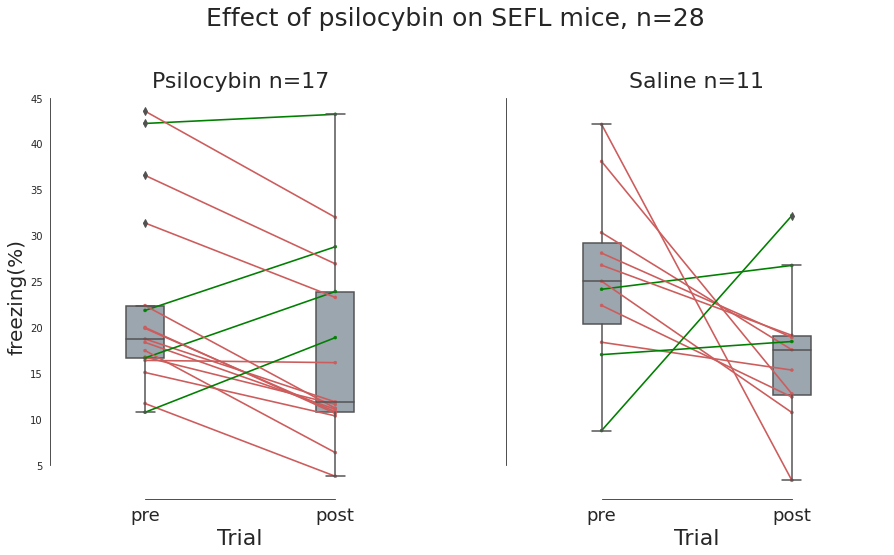

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))
fig.suptitle(f"Effect of psilocybin on SEFL mice, n={sefl}", fontsize=25)
fig.subplots_adjust(top=0.83)

# SEFL + PCB
data = pcb_mice[(pcb_mice['pcb_condition']=='pcb') &
                (pcb_mice['condition']=='SEFL')]
mice = data['cohort_id'].nunique()
pg.plot_paired(data=data, 
                    dv='freezing', within='drug_cond', subject='cohort_id',
                    order=['pre', 'post'], ax=ax1)
ax1.set_title(label=f"Psilocybin n={mice}", fontdict={'fontsize': 22})
ax1.set_ylabel(ylabel='freezing(%)', fontsize=20)

# SEFL + saline
data = pcb_mice[(pcb_mice['pcb_condition']=='sal') &
                (pcb_mice['condition']=='SEFL')]
mice = data['cohort_id'].nunique()
pg.plot_paired(data=data, 
                    dv='freezing', within='drug_cond', subject='cohort_id',
                    order=['pre', 'post'], ax=ax2)
ax2.set_title(label=f"Saline n={mice}", fontdict={'fontsize': 22})

for ax in (ax1,ax2):
  ax.set_xticklabels(['pre', 'post'], fontdict={'fontsize': 18})
  ax.set_xlabel(xlabel='Trial', fontdict={'Fontsize':22})


# fig.savefig(os.path.join(save_path, 'Effect of pcb on SEFLpairplot.png'),
#             transparent=True, dpi=300)

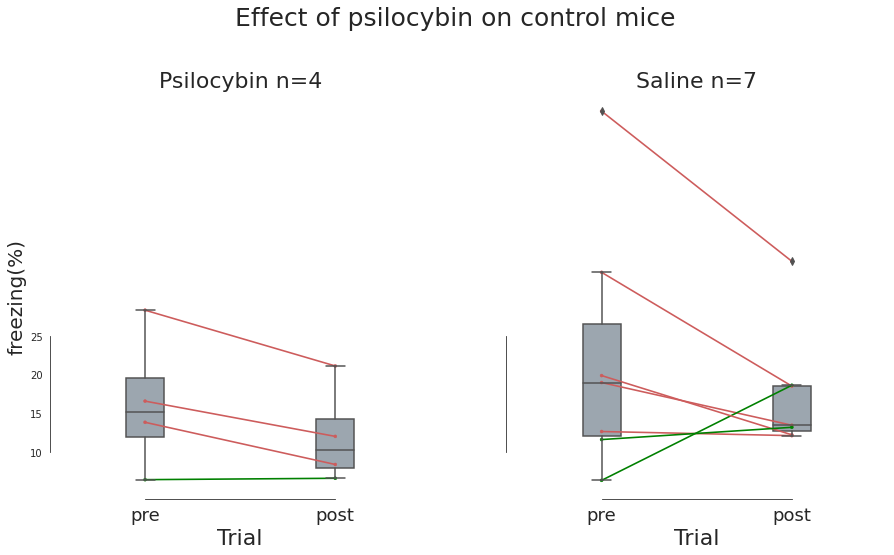

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))
title=fig.suptitle('Effect of psilocybin on control mice', fontsize=25)
fig.subplots_adjust(top=0.83)

# control + PCB
data = pcb_mice[(pcb_mice['pcb_condition']=='pcb') &
                (pcb_mice['condition']=='control')]
mice = data['cohort_id'].nunique()
pg.plot_paired(data=data, 
                    dv='freezing', within='drug_cond', subject='cohort_id',
                    order=['pre', 'post'], ax=ax1)
ax1.set_title(label=f"Psilocybin n={mice}", fontdict={'fontsize': 22})
ax1.set_ylabel(ylabel='freezing(%)', fontsize=20)

# control + saline
data = pcb_mice[(pcb_mice['pcb_condition']=='sal') &
                (pcb_mice['condition']=='control')]
mice = data['cohort_id'].nunique()
pg.plot_paired(data=data, 
                    dv='freezing', within='drug_cond', subject='cohort_id',
                    order=['pre', 'post'], ax=ax2)
ax2.set_title(label=f"Saline n={mice}", fontdict={'fontsize': 22})

for ax in (ax1,ax2):
  ax.set_xticklabels(['pre', 'post'], fontdict={'fontsize': 18})
  ax.set_xlabel(xlabel='Trial', fontdict={'Fontsize':22})

figname = title.get_text()+'.png'
fig.savefig(os.path.join(save_path, figname),
            transparent=True, dpi=300)

In [ ]:
# this is not the way to go

# # Mixed Anova
# res = pg.mixed_anova(data=pcb_mice[pcb_mice['condition']=='SEFL'],
#                      dv='freezing', between='pcb_condition',
#                      within='drug_cond', subject='cohort_id')
# res

In [ ]:
# One Way ANOVA
homeo = pg.homoscedasticity(data=pcb_mice[pcb_mice['condition']=='SEFL'],
                                dv='freezing', group='pcb_condition')
print(homeo)
res_anova = pg.anova(data=pcb_mice[pcb_mice['condition']=='SEFL'],
                     dv='freezing', between='pcb_condition')
print('===========')
res_anova

               W      pval  equal_var
levene  0.048512  0.826504       True


,Source,ddof1,ddof2,F,p-unc,np2
0,pcb_condition,1,54,0.220097,0.640854,0.004059


In [ ]:
new_data = pcb_mice[(pcb_mice['condition']=='SEFL') &
                ((pcb_mice['condition']=='SEFL')&(pcb_mice['freezing']<30))]
new_data

# filtering doesn't owrk that way. it takes out the freezers from the control 
# group as well

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))
# fig.suptitle('Effect of psilocybin on SEFL mice', fontsize=25)
# fig.subplots_adjust(top=0.83)

# data = new_data[(new_data['pcb_condition']=='pcb') &
#                 (new_data['condition']=='SEFL')]
# pg.plot_paired(data=data, 
#                     dv='freezing', within='drug_cond', subject='cohort_id',
#                     order=['pre', 'post'], ax=ax1)
# ax1.set_title(label='Psilocybin', fontdict={'fontsize': 22})
# ax1.set_ylabel(ylabel='freezing(%)', fontsize=20)

# data = new_data[(new_data['pcb_condition']=='sal') &
#                 (new_data['condition']=='SEFL')]
# pg.plot_paired(data=data, 
#                     dv='freezing', within='drug_cond', subject='cohort_id',
#                     order=['pre', 'post'], ax=ax2)
# ax2.set_title(label='Saline', fontdict={'fontsize': 22})

# for ax in (ax1,ax2):
#   ax.set_xticklabels(['pre', 'post'], fontdict={'fontsize': 18})
#   ax.set_xlabel(xlabel='Trial', fontdict={'Fontsize':22})


# # fig.savefig(os.path.join(save_path, 'pcb_onSEFL_pairplot'),
# #             transparent=True, dpi=300)

,cohort_id,freezing,condition,pcb_condition,drug_cond
1,ptsd3_12,24.122000,SEFL,sal,pre
4,ptsd3_5,16.728001,SEFL,pcb,pre
6,ptsd3_9,19.962000,SEFL,pcb,pre
7,ptsd3_11,18.705999,SEFL,pcb,pre
12,ptsd4_62,22.358000,SEFL,sal,pre
13,ptsd4_63,18.332001,SEFL,pcb,pre
14,ptsd4_64,16.642000,SEFL,pcb,pre
15,ptsd4_72,18.346001,SEFL,sal,pre
16,ptsd4_73,16.370001,SEFL,pcb,pre
17,ptsd4_74,19.860001,SEFL,pcb,pre


In [ ]:
res = pg.mixed_anova(data=pcb_mice[pcb_mice['condition']=='control'],
                     dv='freezing', between='pcb_condition',
                     within='drug_cond', subject='cohort_id')
res

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,pcb_condition,94.287290,1,6,94.287290,0.304462,0.601030,0.048293,NaN
1,drug_cond,113.241489,1,6,113.241489,2.089969,0.198403,0.258341,1.0
2,Interaction,4.343047,1,6,4.343047,0.080155,0.786602,0.013183,NaN
